Josías Parra

José P. De la Rosa

## Objetivo.

Implementar un modelo de clasificación facial basado en el uso de _Support Vector Machines_ mediante _sklearn_, utilizando como set de datos de Entrenamiento/Evaluación el conjunto de rostros _Olivetti_: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html 

## Antecedentes.

Este trabajo recupera la implementación de [1] de un modelo de reconocimiento facial, utilizada para  la clasificación del set de datos _Labeled Faces in the Wild_

## Set de datos.

El set de datos _Olivetti_ contiene un conjunto de imágenes faciales tomadas entre los años 1992-1994 en los laboratorios de AT&T Cambridge. 

Este conjunto consiste en una colección de 400 fotografías recuperadas de 40 participantes; 10 fotografías tomadas de manera frontal a cada sujeto, recopiladas con variaciones en el tiempo de captura,  luz, expresión facial y accesorios faciales. 

Este set puede ser recuperado por medio de la función sklearn.datasets.fetch_olivetti_faces en un formato de 64x64 pixeles. Como salida, esta función devuelve un objeto con los siguientes atributos:

<b>data </b>: Arreglo de Numpy de tamaño (400, 4096)
Cada fila corresponde a una imagen de cara delineada del tamaño original de 64 x 64 píxeles. 

<b>images</b>: Arreglo de Numpy de tamaño (400, 64, 64)
Cada fila es una imagen facial correspondiendo a uno de los 40 sujetos.

<b>target</b>: _numpy array_ de tamaño (400, )
Etiquetas asociadas a cada imagen. Estas se hallan en un rango de 0-39 y corresponden a los números de ID de los sujetos.

<b>DESCR</b>: string
Descripcion del set de datos. 

Ver más información de la función  sklearn.datasets.fetch_olivetti_faces en: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces

In [187]:
from sklearn.datasets import fetch_olivetti_faces
#Recuperar dataset de Olivetti y asignar objeto de salida a caras
caras = fetch_olivetti_faces()
#Desplegar descipción de dataset y etiquetas de imágenes. 
print(caras.DESCR)
print(caras.target)

Modified Olivetti faces dataset.

The original database was available from

    http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

The version retrieved here comes in MATLAB format from the personal
web page of Sam Roweis:

    http://www.cs.nyu.edu/~roweis/

There are ten different images of each of 40 distinct subjects. For some
subjects, the images were taken at different times, varying the lighting,
facial expressions (open / closed eyes, smiling / not smiling) and facial
details (glasses / no glasses). All the images were taken against a dark
homogeneous background with the subjects in an upright, frontal position (with
tolerance for some side movement).

The original dataset consisted of 92 x 112, while the Roweis version
consists of 64x64 images.

[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7


Algunas imágenes obtenidas pueden ser visualizadas por medio de la librería Seaborn.

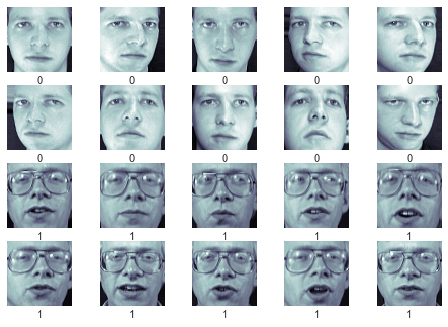

In [201]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()
fig, ax = plt.subplots(4, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(caras.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=caras.target[i])

## Modelo de SVM.

Este set de datos puede ser dividido en un conjunto de datos de entrenamiento y de evaluación por medio de la función sklearn.model_selection.train_test_split

In [189]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(caras.data, caras.target,
                                                random_state=42)

Se crea un modelo que utilizará un análisis de componentes principales (PCA) para extraer 150 características fundamentales de las imágenes.

In [190]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(svd_solver='randomized', n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

Finalmente, [1] recomienda usar una validación cruzada de búsqueda de cuadrículas (grid search) para explorar combinaciones de parámetros, y determinar el mejor modelo:

In [202]:
from sklearn.model_selection import GridSearchCV
#C controla rigidez de los márgenes. +
#Gamma controla el tamaño de base radial del kernel

param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 32.8 s, sys: 1.76 s, total: 34.6 s
Wall time: 17.1 s
{'svc__C': 5, 'svc__gamma': 0.001}


## Predicciones

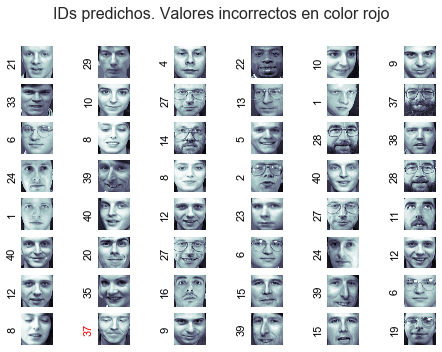

In [203]:
#Realizar predicciones
model = grid.best_estimator_
yfit = model.predict(Xtest)
# Graficar algunas de las predicciones 
fig, ax = plt.subplots(8, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(64, 64), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(yfit[i]+1,
                   color='black' if yfit[i] == ytest[i] else 'red')

    fig.suptitle('IDs predichos. Valores incorrectos en color rojo', size=16);

## Reporte de Clasificación

In [204]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit)) 

             precision    recall  f1-score   support

          0       1.00      0.50      0.67         4
          1       1.00      1.00      1.00         2
          2       0.50      0.50      0.50         2
          3       1.00      1.00      1.00         4
          4       1.00      1.00      1.00         3
          5       1.00      1.00      1.00         3
          6       1.00      1.00      1.00         1
          7       1.00      0.86      0.92         7
          8       1.00      1.00      1.00         2
          9       1.00      1.00      1.00         3
         10       1.00      1.00      1.00         3
         11       1.00      1.00      1.00         4
         12       1.00      1.00      1.00         2
         13       1.00      1.00      1.00         1
         14       1.00      1.00      1.00         3
         15       0.67      1.00      0.80         2
         17       1.00      1.00      1.00         3
         18       1.00      1.00      1.00   

## Referencias

1. Vanderplas, Jacob T. Python Data Science Handbook: Tools and Techniques for Developers. O'Reilly, 2016.